# Sampling from QUBO with OMMX Adapter

Here we explain how to convert a problem to QUBO and perform sampling using the Traveling Salesman Problem as an example.

```{figure} ./assets/taraimawashi_businessman.png
[Illustration of a man in a suit](https://www.irasutoya.com/2017/03/blog-post_739.html)
```

The Traveling Salesman Problem (TSP) is about finding a route for a salesman to visit multiple cities in sequence. Given the travel costs between cities, we seek to find the path that minimizes the total cost. Let's consider the following city arrangement:

In [1]:
# From ulysses16.tsp in TSPLIB
ulysses16_points = [
    (38.24, 20.42),
    (39.57, 26.15),
    (40.56, 25.32),
    (36.26, 23.12),
    (33.48, 10.54),
    (37.56, 12.19),
    (38.42, 13.11),
    (37.52, 20.44),
    (41.23, 9.10),
    (41.17, 13.05),
    (36.08, -5.21),
    (38.47, 15.13),
    (38.15, 15.35),
    (37.51, 15.17),
    (35.49, 14.32),
    (39.36, 19.56),
]

Let's plot the locations of the cities

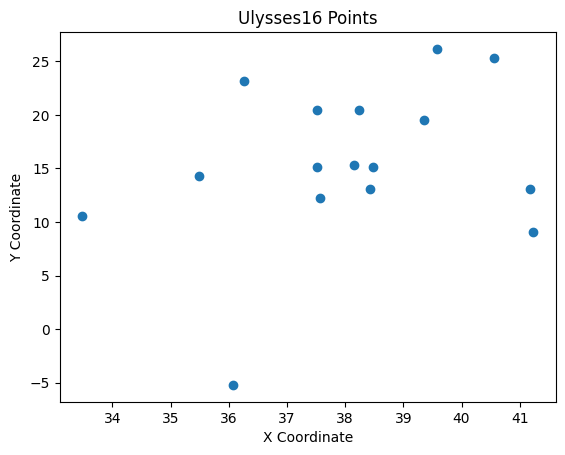

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

x_coords, y_coords = zip(*ulysses16_points)
plt.scatter(x_coords, y_coords)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Ulysses16 Points')
plt.show()

Let's consider distance as the cost. We'll calculate the distance $d(i, j)$ between city $i$ and city $j$.

In [3]:
def distance(x, y):
    return ((x[0] - y[0])**2 + (x[1] - y[1])**2)**0.5

# Number of cities
N = len(ulysses16_points)
# Distance between each pair of cities
d = [[distance(ulysses16_points[i], ulysses16_points[j]) for i in range(N)] for j in range(N)]

Using this, we can formulate TSP as follows. First, let's represent whether we are at city $i$ at time $t$ with a binary variable $x_{t, i}$. Then, we seek $x_{t, i}$ that satisfies the following constraints. The distance traveled by the salesman is given by:

$$
\sum_{t=0}^{N-1} \sum_{i, j = 0}^{N-1} d(i, j) x_{t, i} x_{(t+1 \% N), j}
$$

However, $x_{t, i}$ cannot be chosen freely and must satisfy two constraints: at each time $t$, the salesman can only be in one city, and each city must be visited exactly once:

$$
\sum_{i=0}^{N-1} x_{t, i} = 1, \quad \sum_{t=0}^{N-1} x_{t, i} = 1
$$

Combining these, TSP can be formulated as a constrained optimization problem:

$$
\begin{align*}
\min \quad & \sum_{t=0}^{N-1} \sum_{i, j = 0}^{N-1} d(i, j) x_{t, i} x_{(t+1 \% N), j} \\
\text{s.t.} \quad & \sum_{i=0}^{N-1} x_{t, i} = 1 \quad (\forall t = 0, \ldots, N-1) \\
\quad & \sum_{t=0}^{N-1} x_{t, i} = 1 \quad (\forall i = 0, \ldots, N-1)
\end{align*}
$$

The corresponding `ommx.v1.Instance` can be created as follows:

In [4]:
from ommx.v1 import DecisionVariable, Instance

x = [[
        DecisionVariable.binary(
            i + N * t,  # Decision variable ID
            name="x",           # Name of the decision variable, used when extracting solutions
            subscripts=[t, i])  # Subscripts of the decision variable, used when extracting solutions
        for i in range(N)
    ]
    for t in range(N)
]

objective = sum(
    d[i][j] * x[t][i] * x[(t+1) % N][j]
    for i in range(N)
    for j in range(N)
    for t in range(N)
)
place_constraint = [
    (sum(x[t][i] for i in range(N)) == 1)
        .set_id(t)  # type: ignore
        .add_name("place")
        .add_subscripts([t])
    for t in range(N)
]
time_constraint = [
    (sum(x[t][i] for t in range(N)) == 1)
        .set_id(i + N)  # type: ignore
        .add_name("time")
        .add_subscripts([i])
    for i in range(N)
]

instance = Instance.from_components(
    decision_variables=[x[t][i] for i in range(N) for t in range(N)],
    objective=objective,
    constraints=place_constraint + time_constraint,
    sense=Instance.MINIMIZE
)

The variable names and subscripts added to `DecisionVariable.binary` during creation will be used later when interpreting the obtained samples.

## Converting to QUBO

Many samplers, including OpenJij, operate by generating samples that minimize the objective function described in QUBO (Quadratic Unconstrained Binary Optimization) without constraints. The Traveling Salesman Problem formulated above has all binary variables but includes constraints, making it constrained. Therefore, we convert it to an unconstrained problem by embedding the constraints into the objective function using the penalty method. OMMX's [`Instance.uniform_penalty_method`](https://jij-inc.github.io/ommx/python/ommx/autoapi/ommx/v1/index.html#ommx.v1.Instance.uniform_penalty_method) converts a problem with equality constraints

$$
\begin{align*}
\min \quad &f(x) \\
\text{s.t.} \quad &g_i(x) = 0 \quad (\forall i)
\end{align*}
$$

into an unconstrained problem with a single parameter $\lambda$:

$$
\min \quad f(x) + \lambda \sum_i g_i(x)^2
$$

If you want to specify weight parameters for each constraint, you can use [`Instance.penalty_method`](https://jij-inc.github.io/ommx/python/ommx/autoapi/ommx/v1/index.html#ommx.v1.Instance.penalty_method) to convert it into

$$
\min \quad f(x) + \sum_i \lambda_i g_i(x)^2
$$

OMMX's `Instance.penalty_method` allows for specifying individual weight parameters for each constraint.

In [5]:
parametric_qubo = instance.uniform_penalty_method()

Since this has parameters that are not decision variables, it becomes a `ommx.v1.ParametricInstance` instead of `ommx.v1.Instance`, which corresponds to the following parameterized QUBO:

$$
\min \quad \sum_{t=0}^{N-1} \sum_{i, j = 0}^{N-1} d(i, j) x_{t, i} x_{(t+1 \% N), j}
+ \lambda \left[ \sum_{t=0}^{N-1} \left(\sum_{i=0}^{N-1} x_{t, i} - 1\right)^2
+ \sum_{i=0}^{N-1} \left(\sum_{t=0}^{N-1} x_{t, i} - 1\right)^2 \right]
$$

You can check what parameters the `ParametricInstance` has using the `parameters` property.

In [6]:
parametric_qubo.parameters

,name,subscripts,description
id,,,
256,uniform_penalty_weight,[],<NA>


As explained above, `uniform_penalty_method` has a single penalty weight parameter, so there is only one parameter. To fix this parameter to $\lambda = 20.0$, use `with_parameters` to specify the parameter. This function takes a dictionary `dict[int, float]` that maps parameter IDs to values.

In [7]:
weight = parametric_qubo.get_parameters()[0]
qubo = parametric_qubo.with_parameters({weight.id: 20.0})

The resulting `qubo` now has all parameters substituted, so it is a `ommx.v1.Instance` instead of a `ommx.v1.ParametricInstance`. Additionally, it is an unconstrained optimization problem without any constraints.

In [8]:
assert qubo.get_constraints() == []

However, this `qubo` instance retains the information of the original constraints as `removed_constraints`. This information is used to verify whether the samples obtained from QUBO satisfy the original problem's constraints. Converting to QUBO is an extreme example, but it is common for users to preprocess their mathematical models in such a way that the original constraints become unnecessary before passing them to a solver. Even in such cases, users are interested in the original constraints they input, so `ommx.v1.Instance` includes a mechanism to retain this information.

In [9]:
qubo.removed_constraints.head(2)

,equality,type,used_ids,name,subscripts,description,removed_reason
id,,,,,,,
0,=0,linear,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",place,[0],<NA>,uniform_penalty_method
1,=0,linear,"{16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...",place,[1],<NA>,uniform_penalty_method


Note that the objective function of this `qubo` instance differs from the original problem's objective function. The `objective` value in subsequent processes refers to the value of this new objective function (commonly known as the energy value).


## Sampling with OpenJij

To sample the QUBO described by `ommx.v1.Instance` using OpenJij, use the `ommx-openjij-adapter`.

In [10]:
import ommx_openjij_adapter as adapter

samples = adapter.sample_qubo_sa(qubo, num_reads=16)
sample_set = qubo.evaluate_samples(samples)
sample_set.summary

,objective,feasible
sample_id,,
7,88.631871,True
13,89.788022,True
2,90.836526,True
8,94.200445,True
5,95.088728,True
1,97.170493,True
14,100.667454,True
12,101.839033,True
0,103.567635,True


`ommx_openjij_adapter.sample_qubo_sa` returns `ommx.v1.Samples`, which can be passed to `Instance.evaluate_samples` to calculate the objective function values and constraint violations. The `SampleSet.summary` property is used to display summary information.

- `feasible` indicates the feasibility of the `qubo` instance itself after conversion to QUBO, which is always `True` since QUBO removes all constraints.
- `feasible_unrelaxed` indicates the feasibility with respect to the original problem before conversion to QUBO. This is calculated using the information stored in `removed_constraints` of the `qubo` instance.

To view the feasibility for each constraint, use the `summary_with_constraints` property.

In [11]:
sample_set.summary_with_constraints

,objective,feasible,place[0],place[1],place[2],place[3],place[4],place[5],place[6],place[7],...,time[6],time[7],time[8],time[9],time[10],time[11],time[12],time[13],time[14],time[15]
sample_id,,,,,,,,,,,,,,,,,,,,,
7,88.631871,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
13,89.788022,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,90.836526,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
8,94.200445,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
5,95.088728,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,97.170493,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
14,100.667454,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
12,101.839033,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
0,103.567635,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


For more detailed information, you can use the `SampleSet.decision_variables` and `SampleSet.constraints` properties.

In [12]:
sample_set.decision_variables.head(2)

,kind,lower,upper,name,subscripts,description,substituted_value,0,1,3,...,8,9,10,12,13,14,15,2,7,11
id,,,,,,,,,,,,,,,,,,,,,
0,binary,0.0,1.0,x,"[0, 0]",<NA>,<NA>,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
16,binary,0.0,1.0,x,"[1, 0]",<NA>,<NA>,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
sample_set.constraints.head(2)

,equality,used_ids,name,subscripts,description,removed_reason,value.0,value.1,value.2,value.3,...,feasible.3,feasible.6,feasible.15,feasible.12,feasible.8,feasible.0,feasible.5,feasible.13,feasible.1,feasible.4
id,,,,,,,,,,,,,,,,,,,,,
0,=0,"{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",place,[0],<NA>,uniform_penalty_method,0.0,0.0,0.0,-1.0,...,False,True,True,True,True,True,True,True,True,True
1,=0,"{16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...",place,[1],<NA>,uniform_penalty_method,0.0,0.0,0.0,0.0,...,True,True,True,True,True,True,True,True,True,True



To obtain the samples, use the `SampleSet.extract_decision_variables` method. This interprets the samples using the `name` and `subscripts` registered when creating `ommx.v1.DecisionVariables`. For example, to get the value of the decision variable named `x` with `sample_id=1`, use the following to obtain it in the form of `dict[subscripts, value]`.

In [14]:
sample_id = 1
x = sample_set.extract_decision_variables("x", sample_id)
t = 2
i = 3
x[(t, i)]

0.0

Since we obtained a sample for $x_{t, i}$, we convert this into a TSP path. This depends on the formulation used, so you need to write the processing yourself.

In [15]:
def sample_to_path(sample: dict[tuple[int, ...], float]) -> list[int]:
    path = []
    for t in range(N):
        for i in range(N):
            if sample[(t, i)] == 1:
                path.append(i)
    return path

Let's display this. First, obtain the IDs of samples that are feasible for the original problem.

In [16]:
feasible_ids = sample_set.summary.query("feasible == True").index
feasible_ids

Index([7, 13, 2, 8, 5, 1, 14, 12, 0, 10, 11, 15], dtype='int64', name='sample_id')

Let's display the optimized paths for these samples.

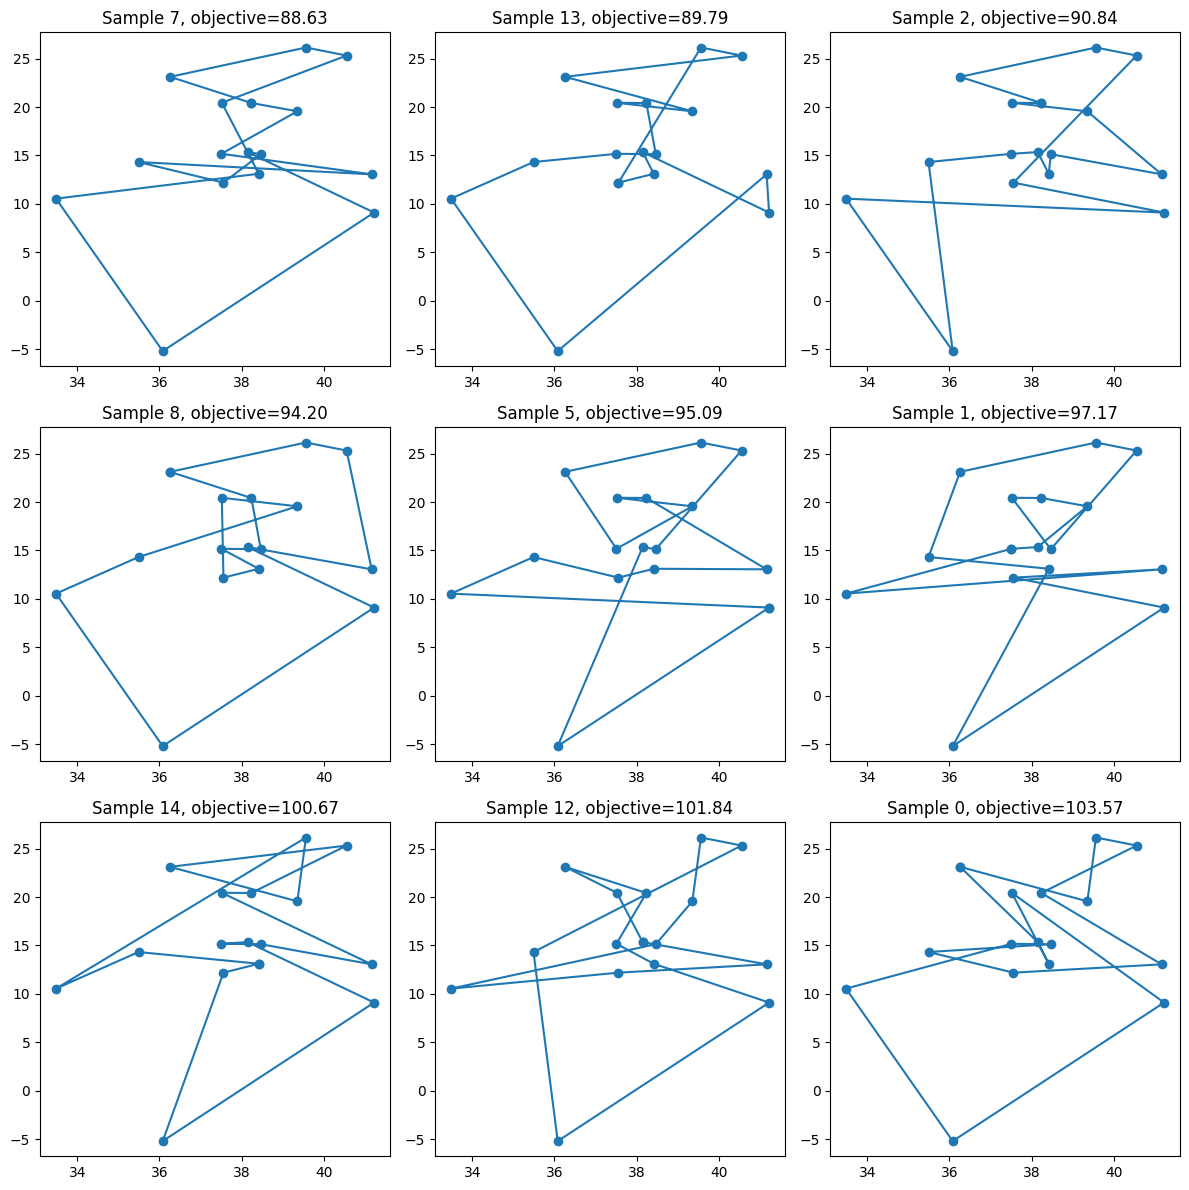

In [17]:
fig, axie = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axie.flatten()):
    if i >= len(feasible_ids):
        break
    s = feasible_ids[i]
    x = sample_set.extract_decision_variables("x", s)
    path = sample_to_path(x)
    xs = [ulysses16_points[i][0] for i in path] + [ulysses16_points[path[0]][0]]
    ys = [ulysses16_points[i][1] for i in path] + [ulysses16_points[path[0]][1]]
    ax.plot(xs, ys, marker='o')
    ax.set_title(f"Sample {s}, objective={sample_set.objectives[s]:.2f}")

plt.tight_layout()
plt.show()